# Import module and prepare function

In [1]:
# import module

from PIL import Image, ImageDraw
import numpy as np
from matplotlib import pyplot as plt
import cv2
import face_recognition

In [2]:
# @desc: 算眉毛中心點座標的函數
# @input: 眉毛特徵座標list
# @return: 眉毛最左最右點的平均座標點(tuple)

def middle_of_eyebrow(eyebrow_landmarks):
    first_x_point = eyebrow_landmarks[0][0]
    last_x_point = eyebrow_landmarks[-1][0]
    first_y_point = eyebrow_landmarks[0][1]
    last_y_point = eyebrow_landmarks[-1][1]
    avg_point = ((first_x_point+last_x_point)/2, (first_y_point+last_y_point)/2)
    return avg_point

In [3]:
# @desc: 將座標轉換成可以畫圓的座標
# @input: 一組座標點(tuple)
# @return: 一組可以畫圓的座標點(tuple)

def transform_2_point(tuple_point):
    l = list(tuple_point)
    l.append(l[0]+5)
    l.append(l[1]+5)
    t = tuple(l)
    return t

In [4]:
# @desc: 將處理眼睛的邏輯包成函式
# @input: 眼睛特徵座標list
# @return: 眼睛特徵點的最高點及最低點座標

def find_eye_feacture_point(eye_landmarks):
    # 找到y軸最高的特徵點
    max_x = 0
    max_y = 0
    for x, y in eye_landmarks:
        if(y > max_y):
            max_y = y
            max_x = x
    
    # 找到y軸最低的特徵點
    min_x = 0
    min_y = max_y
    for x, y in eye_landmarks:
        if(y < min_y):
            min_y = y
            min_x = x
            
    return (max_x, max_y), (min_x, min_y)

# Process image

ex, ey, ew, eh: (88, 121, 60, 60)


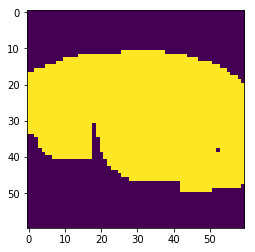

4 points:  (59, 49) (0, 49) (59, 11) (0, 11)
top_point_axis: (240, 282)


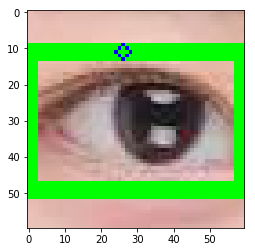

ex, ey, ew, eh: (235, 123, 60, 60)


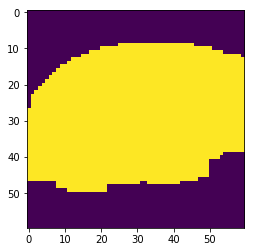

4 points:  (59, 49) (0, 49) (59, 9) (0, 9)
top_point_axis: (386, 282)


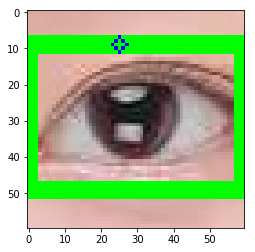

eye_top_points: [(240, 282), (386, 282)]


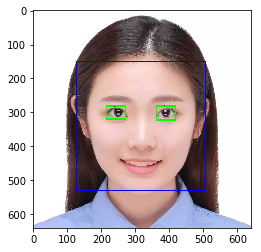

In [5]:
# process eye & eyelid

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')

img = cv2.imread('images/1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

eye_top_points = [] # 左眼、右眼的原圖片最高點座標

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray, 3, 5)
    
    for (ex, ey, ew, eh) in eyes:
        print('ex, ey, ew, eh:', (ex, ey, ew, eh))
        crop_img = roi_color[ey:ey+eh, ex:ex+ew]
        eye_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
        
        # sharpen the image
        # bad...
        # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) # sharpen kernel
        # img_sharpen = cv2.filter2D(eye_gray, -1, kernel)

        # find edge
        edges = cv2.Canny(eye_gray, 100, 200)
        
        # dilation
        closed = cv2.dilate(edges, None, iterations=4)
        plt.imshow(closed)
        plt.show()
        
        # find counter
        _, contours, hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # find eyelid counter's axis
        max_x = 0
        min_x = 5000
        max_y = 0
        min_y = 5000
        top_point_x = 0
        top_point_y = 0
        for point in contours[-1]:
            # find max & min x-axis
            if point[0][0] > max_x:
                max_x = point[0][0]

            if point[0][0] < min_x:
                min_x = point[0][0]

            # find max & min y-axis
            if point[0][1] > max_y:
                max_y = point[0][1]

            if point[0][1] < min_y:
                min_y = point[0][1]
                top_point_y = point[0][1]
                top_point_x = point[0][0]
                
        top_right = (max_x, max_y)
        top_left = (min_x, max_y)
        bottom_right = (max_x, min_y)
        bottom_left = (min_x, min_y)
        
        print('4 points: ', top_right, top_left, bottom_right, bottom_left)
        print('top_point_axis:', (x+ex+top_point_x, y+ey+top_point_y))
        eye_top_points.append((x+ex+top_point_x, y+ey+top_point_y))
        
        # draw counter on the image
        cv2.rectangle(crop_img, top_left, bottom_right, (0,255,0), 3)
        
        # draw top of eye's (contain eyelid) point
        cv2.circle(crop_img, (top_point_x, top_point_y), 2, (255,0,0))
        
        # cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0,255,0),2)
        
        img_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.show()
        
print('eye_top_points:', eye_top_points)       
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

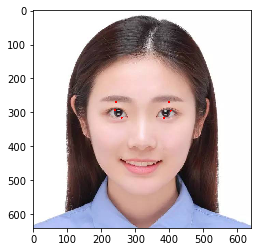

In [6]:
image_path = 'images/1.jpg'
image = face_recognition.load_image_file(image_path)
face_locations  = face_recognition.face_locations(image, number_of_times_to_upsample=1, model="cnn")
image_landmarks = face_recognition.face_landmarks(image, face_locations=face_locations)

for face_landmarks in image_landmarks:
    # 處理left_eyebrow
    left_eyebrow_avg_point = middle_of_eyebrow(face_landmarks['left_eyebrow'])
    # 處理right_eyebrow
    right_eyebrow_avg_point = middle_of_eyebrow(face_landmarks['right_eyebrow'])
    # 處理 left_eye
    left_eye_max_point, left_eye_min_point = find_eye_feacture_point(face_landmarks['left_eye'])
    # 處理 right_eye
    right_eye_max_point, right_eye_min_point = find_eye_feacture_point(face_landmarks['right_eye'])

    
# 把特徵點轉成可以畫圖的座標點
# 眉毛
left_eyebrow_avg_point_tuple = transform_2_point(left_eyebrow_avg_point)
right_eyebrow_avg_point_tuple = transform_2_point(right_eyebrow_avg_point)
# 眼睛
left_eye_max_point_tuple = transform_2_point(left_eye_max_point)
left_eye_min_point_tuple = transform_2_point(left_eye_min_point)
right_eye_max_point_tuple = transform_2_point(right_eye_max_point)
right_eye_min_point_tuple = transform_2_point(right_eye_min_point)

# 把特徵點畫上去
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)
d.ellipse(left_eyebrow_avg_point_tuple, fill=(255, 0, 0))
d.ellipse(right_eyebrow_avg_point_tuple, fill=(255, 0, 0))
d.ellipse(left_eye_max_point_tuple, fill=(255, 0, 0))
d.ellipse(left_eye_min_point_tuple, fill=(255, 0, 0))
d.ellipse(right_eye_max_point_tuple, fill=(255, 0, 0))
d.ellipse(right_eye_min_point_tuple, fill=(255, 0, 0))

plt.imshow(pil_image)
plt.show()

# 整理函式

In [7]:
class RecognitionUtils:
    # @desc: 算眉毛中心點座標的函數
    # @input: {list} 眉毛特徵座標
    # @return: {tuple} 眉毛最左最右點的平均座標點
    @staticmethod
    def middle_of_eyebrow(eyebrow_landmarks):
        first_x_point = eyebrow_landmarks[0][0]
        last_x_point = eyebrow_landmarks[-1][0]
        first_y_point = eyebrow_landmarks[0][1]
        last_y_point = eyebrow_landmarks[-1][1]
        avg_point = ((first_x_point+last_x_point)/2, (first_y_point+last_y_point)/2)
        return avg_point
    
    
    # @desc: 將座標轉換成可以畫圓的座標
    # @input: {tuple} 一組座標點
    # @return: {tuple} 一組可以畫圓的座標點
    @staticmethod
    def transform_2_point(tuple_point):
        l = list(tuple_point)
        l.append(l[0]+5)
        l.append(l[1]+5)
        t = tuple(l)
        return t
    
    
    # @desc: 將處理眼睛的邏輯包成函式
    # @input: {list} 眼睛特徵座標
    # @return: {tuple, tuple} 眼睛特徵點的最高點及最低點座標
    @staticmethod
    def find_eye_feacture_point(eye_landmarks):
        # 找到y軸最高的特徵點
        max_x = 0
        max_y = 0
        for x, y in eye_landmarks:
            if(y > max_y):
                max_y = y
                max_x = x

        # 找到y軸最低的特徵點
        min_x = 0
        min_y = max_y
        for x, y in eye_landmarks:
            if(y < min_y):
                min_y = y
                min_x = x

        return (max_x, max_y), (min_x, min_y)
    
    
    # @desc: 辨識出圖片中眼睛的最高點座標(包含眼皮)
    # @input: {string} 原始圖片位置
    # @return: {list} 第一個為左眼最高點座標, 第二個為右眼最高點座標
    @staticmethod
    def recognize_eye_top_axis(IMG_URL):
        face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
        eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')

        img = cv2.imread(IMG_URL)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        eye_top_points = [] # 左眼、右眼的原圖片最高點座標

        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray, 3, 5)

            for (ex, ey, ew, eh) in eyes:
                crop_img = roi_color[ey:ey+eh, ex:ex+ew]
                eye_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)

                # sharpen the image
                # bad...
                # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) # sharpen kernel
                # img_sharpen = cv2.filter2D(eye_gray, -1, kernel)

                # find edge
                edges = cv2.Canny(eye_gray, 100, 200)

                # dilation
                closed = cv2.dilate(edges, None, iterations=4)

                # find counter
                _, contours, hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # find eyelid counter's axis
                max_x = 0
                min_x = 5000
                max_y = 0
                min_y = 5000
                top_point_x = 0
                top_point_y = 0
                for point in contours[-1]:
                    # find max & min x-axis
                    if point[0][0] > max_x:
                        max_x = point[0][0]

                    if point[0][0] < min_x:
                        min_x = point[0][0]

                    # find max & min y-axis
                    if point[0][1] > max_y:
                        max_y = point[0][1]

                    if point[0][1] < min_y:
                        min_y = point[0][1]
                        top_point_y = point[0][1]
                        top_point_x = point[0][0]

                top_right = (max_x, max_y)
                top_left = (min_x, max_y)
                bottom_right = (max_x, min_y)
                bottom_left = (min_x, min_y)

                eye_top_points.append((x+ex+top_point_x, y+ey+top_point_y))
                
            return eye_top_points
    
    
    # @desc: 辨識眉毛及眼睛座標
    # @input: {string} 原始圖片位置
    # @return: {tuple} 左眉座標, 右眉座標, 左眼低點座標, 右眼低點座標
    @staticmethod
    def recognize_eye_and_eyebrow_axis(IMG_URL):
        image = face_recognition.load_image_file(IMG_URL)
        face_locations  = face_recognition.face_locations(image, number_of_times_to_upsample=1, model="cnn")
        image_landmarks = face_recognition.face_landmarks(image, face_locations=face_locations)

        for face_landmarks in image_landmarks:
            # 處理left_eyebrow
            left_eyebrow_avg_point = middle_of_eyebrow(face_landmarks['left_eyebrow'])
            # 處理right_eyebrow
            right_eyebrow_avg_point = middle_of_eyebrow(face_landmarks['right_eyebrow'])
            # 處理 left_eye
            left_eye_max_point, left_eye_min_point = find_eye_feacture_point(face_landmarks['left_eye'])
            # 處理 right_eye
            right_eye_max_point, right_eye_min_point = find_eye_feacture_point(face_landmarks['right_eye'])
                
        return left_eyebrow_avg_point, right_eyebrow_avg_point, left_eye_max_point, right_eye_max_point
    
    
    # @desc: 將座標點畫點在圖片上
    # @input: {string}圖片位置, {list}要畫的座標點 
    # @return: {img} 繪圖好的圖片
    def draw_point(IMG_URL, draw_points):
        img = cv2.imread(IMG_URL)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(img_rgb)
        d = ImageDraw.Draw(pil_image)
        
        for point in draw_points:
            d.ellipse(transform_2_point(point), fill=(255, 0, 0))

        return pil_image

# 測試

左眼最高點： (240, 282)
右眼最高點： (386, 282)
左眼最低點： (257, 313)
右眼最低點： (383, 315)
左眉： (242.5, 267.5)
右眉： (396.0, 268.5)


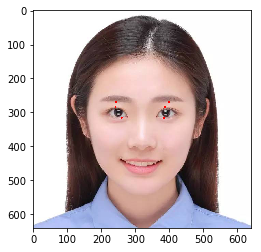

In [8]:
IMG_URL = 'images/1.jpg'

# Variables =================================
# left_eye_top_axis: 左眼最高點座標(包含眼皮)
# left_eye_bottom_axis: 左眼最低點座標
# right_eye_top_axis: 右眼最高點座標(包含眼皮)
# right_eye_bottom_axis: 右眼最低點座標
# left_eyebrow_axis: 左眉毛座標
# right_eyebrow_axis: 右眉毛座標
# ===========================================

[left_eye_top_axis, right_eye_top_axis] = RecognitionUtils.recognize_eye_top_axis(IMG_URL)
left_eyebrow_axis, right_eyebrow_axis, left_eye_bottom_axis, right_eye_bottom_axis = RecognitionUtils.recognize_eye_and_eyebrow_axis(IMG_URL)

print('左眼最高點：',left_eye_top_axis)
print('右眼最高點：', right_eye_top_axis)
print('左眼最低點：', left_eye_bottom_axis)
print('右眼最低點：', right_eye_bottom_axis)
print('左眉：', left_eyebrow_axis)
print('右眉：', right_eyebrow_axis)

draw_points = [left_eye_top_axis, left_eye_bottom_axis, right_eye_top_axis,
               right_eye_bottom_axis, left_eyebrow_axis, right_eyebrow_axis]
drawn_img = RecognitionUtils.draw_point(IMG_URL, draw_points)
plt.imshow(drawn_img)
plt.show()

左眼最高點： (229, 212)
右眼最高點： (127, 212)
左眼最低點： (155, 250)
右眼最低點： (269, 249)
左眉： (139.5, 213.0)
右眉： (265.0, 210.5)


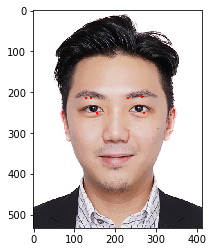

In [9]:
# It's a failure sample
# Because eye recognition has mistake (contain eyebrow)

IMG_URL = 'images/2.jpg'

# Variables =================================
# left_eye_top_axis: 左眼最高點座標(包含眼皮)
# left_eye_bottom_axis: 左眼最低點座標
# right_eye_top_axis: 右眼最高點座標(包含眼皮)
# right_eye_bottom_axis: 右眼最低點座標
# left_eyebrow_axis: 左眉毛座標
# right_eyebrow_axis: 右眉毛座標
# ===========================================

[left_eye_top_axis, right_eye_top_axis] = RecognitionUtils.recognize_eye_top_axis(IMG_URL)
left_eyebrow_axis, right_eyebrow_axis, left_eye_bottom_axis, right_eye_bottom_axis = RecognitionUtils.recognize_eye_and_eyebrow_axis(IMG_URL)

print('左眼最高點：',left_eye_top_axis)
print('右眼最高點：', right_eye_top_axis)
print('左眼最低點：', left_eye_bottom_axis)
print('右眼最低點：', right_eye_bottom_axis)
print('左眉：', left_eyebrow_axis)
print('右眉：', right_eyebrow_axis)

draw_points = [left_eye_top_axis, left_eye_bottom_axis, right_eye_top_axis,
               right_eye_bottom_axis, left_eyebrow_axis, right_eyebrow_axis]
drawn_img = RecognitionUtils.draw_point(IMG_URL, draw_points)
plt.imshow(drawn_img)
plt.show()